# Download World Bank (WB) data

Uses the World Bank API to download the macro indicators that we require. 

In [1]:
import pandas as pd 
from pandas_datareader import wb
import os 

In [2]:
assert os.path.isdir('./input'), f'Please create directory, "input", in this folder (output will be stored there).'
assert os.path.isfile('./input/country_codes.csv'), f'File, "input/country_codes.csv", not found.'

## Choose variables to be downloaded and assign names

In [3]:
# variables including shorter names 
indicators = ['SP.POP.TOTL','NY.GDP.PCAP.KD','NE.GDI.TOTL.ZS', 'NY.GDP.MKTP.KD']
ind_short = {'NE.GDI.TOTL.ZS':'capital_growth_pct_gdp',
           'SP.POP.TOTL':'population', 
           'NY.GDP.PCAP.KD':'gdp_pc',
           'NY.GDP.MKTP.KD':'gdp',
}

In [4]:
# just for completeness, here are the official descriptions of the variables
ind_lbl = {'NE.GDI.TOTL.ZS':'Gross capital formation (% of GDP)',
           'SP.POP.TOTL':'Total population', 
           'NY.GDP.PCAP.KD':'GDP per capita',
           'NY.GDP.MKTP.KD':'GDP (total)'
          }

## Download data from API 

In [5]:
# rename country identifiers
ren = {'name': 'country', 'iso3c':'code'}
wb_countries = wb.get_countries()[['name', 'iso3c']].rename(columns=ren)

# find the countries 
#countries = wb_countries.code.unique() # this list contains codes that we cannot find data for (aggregated regions)
countries = pd.read_csv('input/country_codes.csv').query('code != "YUG"').code.unique() #YUG cannot be found in WB, it seems

In [6]:
# call the API
wb_raw = wb.download(indicator=indicators, country=countries, start=1960, end=2020)

/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: ADO, ANT, CHI, IMY, ROM, TMP, WBG, ZAR
  warnings.warn(


Some minor cleanup and renaming

In [7]:
wb_gdp = wb_raw.reset_index()
wb_gdp = wb_gdp.rename(columns = ind_short)
wb_gdp.year = wb_gdp.year.astype(int)

### Merge on the ISO3 code

For some reason, the returned dataframe from the WB API only has the country name and not the ISO3 code. 

In [8]:
wb_final = pd.merge(wb_gdp, wb_countries, on='country', how='left')
wb_final.drop('country', axis=1, inplace=True) #we will merge on the code

In [9]:
# make "code" the first variable
wb_final = wb_final.iloc[:, [-1] + [i for i in range(wb_final.shape[1]-1)]]

## Export data

In [10]:
wb_final.to_csv('./input/world_bank.csv', index=False)

# Check availability

GDP is a key variable restricting what we can analyze. Let's see how many countries we have GDP for in the first year

In [11]:
I = wb_final.year == 1960
var = 'gdp_pc' 
wb_final.loc[I, [var]].notnull().sum()

gdp_pc    88
dtype: int64

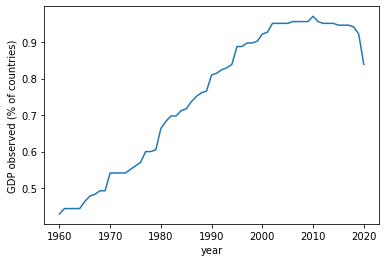

In [12]:
ax=wb_final.groupby('year').gdp_pc.agg(lambda x : x.notnull().mean()).plot();
ax.set_ylabel('GDP observed (% of countries)');

# Key growth scatterplot

Computing compound annual growth rates: 
$$ g = \left( \frac{y_T}{y_1} \right)^{\frac{1}{T}} - 1 $$

In [14]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme()

In [15]:
def annual_growth_rate(x1, x0, year1, year0):
    """ Calculate compound growth rate from x0 to x """      
    num_periods = year1-year0 #used from global memory 
    return (x1/x0)**(1./num_periods)-1.

In [16]:
def show_scatter(year0, year1, DOSAVE=False):
    # add to labels 
    lbl_all = dict()
    lbl_all['lgdp_initial'] = f'GDP p.c. in {year0} (log)'
    lbl_all['lpop_initial'] = f'Population in {year0} (log)'
    lbl_all['gdp_growth'] = f'Annual growth in GDP p.c., {year0}-{year1}'

    yy = [year0, year1]
    data = wb_final[wb_final.year.isin(yy)].sort_values(['code', 'year']).set_index('code')
    d0 = data[data.year == year0] # first year 
    d1 = data[data.year == year1] # last year 
    
    # initialize our key data frame: it will contain just a single row per country 
    dat = d0[[]].copy() #just the index, no columns
    assert dat.index.is_unique, f'Unexpected non-uniqueness: multiple country-year observations?'
    
    # create variables 
    dat['lpop_initial'] = np.log(d0.population)
    dat['lgdp_initial'] = np.log(d0.gdp_pc)
    dat['lgdp_now']     = np.log(d1.gdp_pc)
    dat['gdp_growth']   = annual_growth_rate(d1.gdp_pc, d0.gdp_pc, year1, year0)

    # only keep rows where we observe gdp growth 
    I = dat[['gdp_growth', 'lpop_initial']].notnull().all(1)
    dat = dat[I].copy()
    print(f'N = {I.sum()} countries have data on growth')
    
    s = np.exp(dat.lpop_initial)/1_000_000 #the size of markers will be proportional to this
    
    # create primary scatterplot 
    ax=dat.plot.scatter(x='lgdp_initial', y='gdp_growth', s=s, c='navy', alpha=0.4);
    ax.set_xlabel(lbl_all['lgdp_initial']); 
    ax.set_ylabel(lbl_all['gdp_growth']);
    
    # add country names for *some* of the countries
    countries = dat.sort_values('lpop_initial', ascending=False).head(5).index.values; # largest in pop.
    countries = np.append(countries, dat.sort_values('gdp_growth', ascending=False).head(8).index.values); # largest growth
    countries = np.append(countries, dat.sort_values('gdp_growth', ascending=False).tail(3).index.values); # smallest growth
    countries = np.append(countries, 'DNK'); # because narcisism, also include Denmark
    J = dat.index.isin(countries) # boolean: these rows will get their names printed
    for country,row in dat[J].iterrows(): 
        ax.text(row.lgdp_initial*1.01, row.gdp_growth*1.01, country, c='darkmagenta')
    
    if DOSAVE: 
        if os.path.isdir('./img'): # is there an img directory here? 
            fname = f'img/scatter_growth_{year0}_{year1}.pdf'
        else: 
            fname = f'scatter_growth_{year0}_{year1}.pdf'
        plt.savefig(fname)

N = 104 countries have data on growth


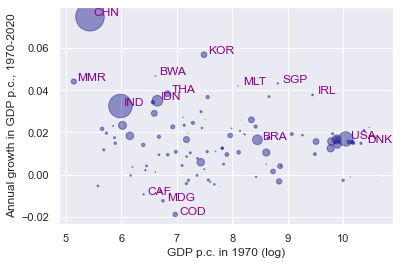

In [17]:
# Primary sample 
show_scatter(1970, 2020, DOSAVE=True)

N = 88 countries have data on growth


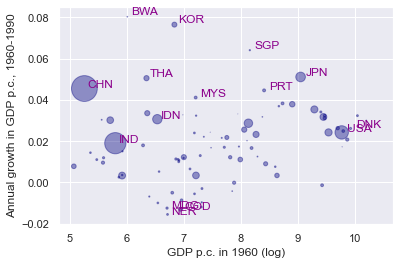

In [18]:
show_scatter(1960, 1990, DOSAVE=True)

N = 151 countries have data on growth


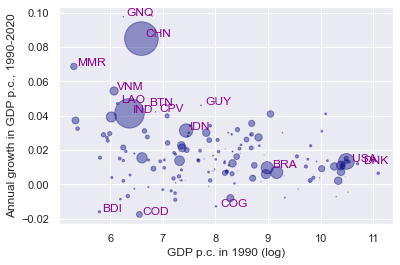

In [19]:
show_scatter(1990, 2020, DOSAVE=True)